# This notebook represents our full pipeline of our first semester work. Starts with pulling in our bad data and scraping our good data, then using NER and wordnet to create features, and then finally we use machine learning to predict values

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

import os
from dotenv import load_dotenv
load_dotenv()

CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET=os.getenv('CLIENT_SECRET')
APP_NAME=os.getenv('APP_NAME')
REDDIT_USERNAME=os.getenv('REDDIT_USERNAME')
REDDIT_PASSWORD=os.getenv('REDDIT_PASSWORD')

import praw
import pandas as pd
import datetime as dt

reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, user_agent=APP_NAME, username=REDDIT_USERNAME, password=REDDIT_PASSWORD)

print(reddit.user.me())

%matplotlib inline

mattcat26


Next, we are going to read in the bad comment data given to us by a moderator of the 'neutralnews' subreddit.

In [34]:
import gzip
import shutil
with gzip.open('./neutralnews-2020-09-27.json.gz', 'rb') as f_in:
    with open('neutralnews-2020-09-27.json', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [35]:
comment_df = pd.read_json('neutralnews-2020-09-27.json', orient='records')

In [36]:
new_comment_df = comment_df[["action", "content", "author", "details", "submissionId", "id"]]
bad_comment_data = new_comment_df.rename(columns={"id" : "commentId"})
bad_comment_data


,action,content,author,details,submissionId,commentId
0,removecomment,"How is this""neutral news""? Literally, it's rep...",b756df5867ce042f3a07f3037e5eeeb9,Rule 5: top-level comment has no links,cgd7ut,5dea4ee94af43200093a2f4c
1,removecomment,Just wondering if you have any updates.,58843f7430c71f72208766a295eaae5e,Low effort top-level comment,cim6kf,5dea4ee94af43200093a2f4d
2,removecomment,.,f9dcef98ec140a8f44d5691d34081408,Rule 5: top-level comment has no links,cfzkky,5dea4ee94af43200093a2f4e
3,removecomment,I went to park,aab8641b0dc26f59e9c8fea95f470138,Low effort top-level comment,asrdao,5dea4ee94af43200093a2f4f
4,removecomment,"Hi, u/SFepicure\n\n[I think you may enjoy this...",e48fe0135108ee9985e260caf57cc6e0,remove,b47a1d,5dea4ee94af43200093a2f50
...,...,...,...,...,...,...
5997,removecomment,Oh I thought we were posting arbitrary facts t...,38e2216dc3dc2cb196cbf4bab0d83541,remove,j0ijwn,5f70e968dbe1ef0009d976e7
5998,removecomment,No. The senate is not wasting time to fill th...,c4f22a6532a4ca274c5027e4bc3d3d99,remove,j0ijwn,5f70e968dbe1ef0009d976e9
5999,approvecomment,"My point was not addressed, regarding providin...",062512f6041e1c40256c31f31a1138fc,unspam,j04eqv,5f70ee18dbe1ef0009d97717
6000,removecomment,Voting has begun in some states but the debate...,c696933b8cbd4b625077d6b577bac0fe,remove,j0ijwn,5f70f3f4dbe1ef0009d9775e


In [37]:
new_arr = bad_comment_data['submissionId'].to_list()
new_arr = np.array(new_arr)
submissions = np.unique(new_arr)
submissions = submissions.tolist()
submissions

['4o2o29',
 '4op948',
 '4sef35',
 '5x0k84',
 '64zsim',
 '68qqfz',
 '6907e3',
 '6mmw91',
 '6n161i',
 '6oftmx',
 '6xapy0',
 '7307wv',
 '76z4xh',
 '7ht8tj',
 '7hyg56',
 '7z5dyt',
 '804o3f',
 '862sn6',
 '8d0t2m',
 '8e7lrz',
 '8go559',
 '8hz10r',
 '8uby76',
 '8x2571',
 '8zp0uh',
 '91gwrp',
 '94q8j7',
 '96nrmf',
 '99fccg',
 '9c88xn',
 '9f2i6b',
 '9fj3m8',
 '9h0mo6',
 '9h82yb',
 '9ht83g',
 '9iqed1',
 '9j3gvd',
 '9jpdh7',
 '9kq8xy',
 '9ood1n',
 '9rbpt8',
 '9s3gd8',
 '9smhsl',
 '9xyyt0',
 '9zonfn',
 'a4tn3i',
 'a67z1j',
 'aab5gq',
 'ab7m8y',
 'ac7d56',
 'acz2f9',
 'ahxiba',
 'ailn92',
 'aj96gr',
 'ajvsq6',
 'alzqd0',
 'an9m5u',
 'andfa8',
 'apss2q',
 'asacv6',
 'asrdao',
 'auz29y',
 'axnhrj',
 'b47a1d',
 'b7e8o4',
 'b8cd1q',
 'b9d62h',
 'bj3tgb',
 'bjngf5',
 'bka66t',
 'blxd09',
 'bpi7u6',
 'busrz0',
 'bv8dl8',
 'bvk72a',
 'bxtj3y',
 'byiwll',
 'c109ai',
 'c3swuk',
 'c75b2i',
 'c7nqp7',
 'cess35',
 'cfa7tc',
 'cfa99a',
 'cfc5qa',
 'cfzkky',
 'cgd7ut',
 'cgks97',
 'cgkspq',
 'cgktg9',
 'cgkueu',

In [38]:
topics_dict = {'title':[], 'score':[], 'id':[], 'url':[], 'comms_num': [], 'created':[], 'body':[]}

for list_submission in submissions:
    submission = reddit.submission(id=list_submission)
    topics_dict['title'].append(submission.title)
    topics_dict['score'].append(submission.score)
    topics_dict['id'].append(submission.id)
    topics_dict['url'].append(submission.url)
    topics_dict['comms_num'].append(submission.num_comments)
    topics_dict['created'].append(submission.created)
    topics_dict['body'].append(submission.selftext)
topics_data = pd.DataFrame(topics_dict)

Now, we are going to parse in good comment data by scraping the neutral news subreddit.

In [39]:
comments_dict = {"action": [], "content": [], "author": [], "details": [], "submissionId": [], "commentId": []}

In [40]:
subreddit = reddit.subreddit('neutralnews')

for list_submission in submissions:
    submission = reddit.submission(id=list_submission)
    #print(submission.title, submission.id)
    submission.comments.replace_more(limit=100)
    for comment in submission.comments:
        #print(top_level_comment.body)
        comments_dict["action"].append(np.nan)
        comments_dict["content"].append(comment.body)
        comments_dict["author"].append(comment.author)
        comments_dict["details"].append(np.nan)
        comments_dict["submissionId"].append(submission.id)
        comments_dict["commentId"].append(comment.id)

good_comment_data = pd.DataFrame(comments_dict)

In [41]:
good_comment_data = good_comment_data[good_comment_data['author'] != 'AutoModerator']

In [42]:
good_comment_data = good_comment_data.reset_index()

In [43]:
good_comment_data = good_comment_data.drop(['index'], axis=1)
good_comment_data

,action,content,author,details,submissionId,commentId
0,NaN,"Just wanted to say ""thanks"" publicly. I'm ver...",zaphnod,NaN,4o2o29,d498hvk
1,NaN,"Hi, thanks for making this sub. A couple quest...",niugnep24,NaN,4o2o29,d49b7t2
2,NaN,"I'd like to say thanks to our ""focus group"" pa...",nosecohn,NaN,4o2o29,d498cxc
3,NaN,[removed],None,NaN,4o2o29,d4997am
4,NaN,"Can we get ""Moderator Activity Log"" for /r/Neu...",bloodguard,NaN,4o2o29,d49d04t
...,...,...,...,...,...,...
2606,NaN,"r/NeutralNews is a **curated space**, but desp...",NeutralverseBot,NaN,j0ijwn,g6rh4no
2607,NaN,__I'm a bot. Here are The Factual credibility ...,TheFactualBot,NaN,j0ijwn,g6rhg7f
2608,NaN,[removed],None,NaN,j0ijwn,g6ud0cs
2609,NaN,[removed],None,NaN,j0ijwn,g6ukt21


We can now combine the good comment data and bad comment data into one dataframe.

In [44]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime('%H:%M:%S')
print('current time = ', current_time)

current time =  21:41:29


In [47]:
good_comment_data.to_csv("good_comment_data_119.csv", index=False)
bad_comment_data.to_csv("bad_comment_data_119.csv", index=False)

In [6]:
from newspaper import Article
from newspaper import Config

user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent

import spacy
from spacy import displacy
from collections import Counter
#!python -m spacy download en_core_web_lg
#!pip install spacy-wordnet

import en_core_web_lg
nlp = en_core_web_lg.load()

from spacy_wordnet.wordnet_annotator import WordnetAnnotator
nlp.add_pipe(WordnetAnnotator(nlp.lang), after='tagger')


STOP_WORDS = spacy.lang.en.stop_words.STOP_WORDS

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [52]:
frames = [good_comment_data, bad_comment_data]
comment_data = pd.concat(frames, ignore_index=True)
comment_data

,action,content,author,details,submissionId,commentId
0,NaN,"Just wanted to say ""thanks"" publicly. I'm ver...",zaphnod,NaN,4o2o29,d498hvk
1,NaN,"Hi, thanks for making this sub. A couple quest...",niugnep24,NaN,4o2o29,d49b7t2
2,NaN,"I'd like to say thanks to our ""focus group"" pa...",nosecohn,NaN,4o2o29,d498cxc
3,NaN,[removed],None,NaN,4o2o29,d4997am
4,NaN,"Can we get ""Moderator Activity Log"" for /r/Neu...",bloodguard,NaN,4o2o29,d49d04t
...,...,...,...,...,...,...
8608,removecomment,Oh I thought we were posting arbitrary facts t...,38e2216dc3dc2cb196cbf4bab0d83541,remove,j0ijwn,5f70e968dbe1ef0009d976e7
8609,removecomment,No. The senate is not wasting time to fill th...,c4f22a6532a4ca274c5027e4bc3d3d99,remove,j0ijwn,5f70e968dbe1ef0009d976e9
8610,approvecomment,"My point was not addressed, regarding providin...",062512f6041e1c40256c31f31a1138fc,unspam,j04eqv,5f70ee18dbe1ef0009d97717
8611,removecomment,Voting has begun in some states but the debate...,c696933b8cbd4b625077d6b577bac0fe,remove,j0ijwn,5f70f3f4dbe1ef0009d9775e


In [7]:
good_comment_data = pd.read_csv('good_comment_data_119.csv')
bad_comment_data = pd.read_csv('bad_comment_data_119.csv')
frames = [good_comment_data, bad_comment_data]
comment_data = pd.concat(frames, ignore_index=True)
comment_data

,action,content,author,details,submissionId,commentId
0,NaN,"Just wanted to say ""thanks"" publicly. I'm ver...",zaphnod,NaN,4o2o29,d498hvk
1,NaN,"Hi, thanks for making this sub. A couple quest...",niugnep24,NaN,4o2o29,d49b7t2
2,NaN,"I'd like to say thanks to our ""focus group"" pa...",nosecohn,NaN,4o2o29,d498cxc
3,NaN,[removed],NaN,NaN,4o2o29,d4997am
4,NaN,"Can we get ""Moderator Activity Log"" for /r/Neu...",bloodguard,NaN,4o2o29,d49d04t
...,...,...,...,...,...,...
8608,removecomment,Oh I thought we were posting arbitrary facts t...,38e2216dc3dc2cb196cbf4bab0d83541,remove,j0ijwn,5f70e968dbe1ef0009d976e7
8609,removecomment,No. The senate is not wasting time to fill th...,c4f22a6532a4ca274c5027e4bc3d3d99,remove,j0ijwn,5f70e968dbe1ef0009d976e9
8610,approvecomment,"My point was not addressed, regarding providin...",062512f6041e1c40256c31f31a1138fc,unspam,j04eqv,5f70ee18dbe1ef0009d97717
8611,removecomment,Voting has begun in some states but the debate...,c696933b8cbd4b625077d6b577bac0fe,remove,j0ijwn,5f70f3f4dbe1ef0009d9775e


In [93]:
import nltk
nltk.download('wordnet')

from datetime import datetime
now = datetime.now()
current_time = now.strftime('%H:%M:%S')
print('current time = ', current_time)

def clean_articles(topics_data, comment_data, text_list):
    for url in topics_data['url']:
        try:
            article = Article(url, language='en', fetch_images=False, config = config)
            article.download()
            article.parse()
            art_text = article.text
            art_doc = nlp(art_text.lower())
            text_list.append(art_doc)
        #if there is an exception, remove comments that go with this article
        except:
            text_list.append("error")
            subId = topics_data[topics_data['url'] == url]['id']
            subId = subId.to_numpy()
            subId = subId[0]
            comment_data = comment_data[comment_data['submissionId'] != subId]
            continue
    topics_data['text'] = text_list

clean_articles(topics_data, comment_data, [])
# url = 'https://www.washingtonpost.com/world/national-security/sessions-spoke-twice-with-russian-ambassador-during-trumps-presidential-campaign-justice-officials-say/2017/03/01/77205eda-feac-11e6-99b4-9e613afeb09f_story.html?hpid=hp_rhp-top-table-main_no-name%3Ahomepage%2Fstory&utm_term=.f2a14c329123'
# subId = topics_data[topics_data['url'] == url]['id']
# subId = subId.to_numpy()
# subId = subId[0]
# subId

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mattc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
current time =  23:16:59


In [96]:
topics_data.to_csv("topics_data_119.csv", index=False)

In [8]:
topics_data = pd.read_csv('topics_data_119.csv')
topics_data

,title,score,id,url,comms_num,created,body,text
0,[META] Welcome to NeutralNews,225,4o2o29,https://www.reddit.com/r/neutralnews/comments/...,66,1.465955e+09,The goal of /r/NeutralNews is to provide a pla...,the goal of r/neutralnews is to provide a plac...
1,Wall Street has been rocked by an $8 billion h...,183,4op948,http://www.businessinsider.com/visium-asset-ma...,10,1.466297e+09,NaN,"jake gottlieb, the founder of visium. reuters/..."
2,How a $2 Roadside Drug Test Sends Innocent Peo...,91,4sef35,http://www.nytimes.com/2016/07/10/magazine/how...,11,1.468315e+09,NaN,field tests provide quick answers. but if thos...
3,Sessions spoke twice with Russian ambassador d...,668,5x0k84,https://www.washingtonpost.com/world/national-...,84,1.488450e+09,NaN,error
4,The Russia story just keeps getting worse for ...,90,64zsim,http://www.cnn.com/2017/04/12/politics/trump-c...,31,1.492048e+09,NaN,washington (cnn) two stories dealing with russ...
...,...,...,...,...,...,...,...,...
531,Trump falsely claimed an incident where an ele...,9,j078ii,https://www.businessinsider.com/trump-falsely-...,39,1.601160e+09,NaN,president donald trump falsely claimed that an...
532,‘It’s like every red flag’: Trump-ordered HHS ...,5,j099m5,https://www.politico.com/news/2020/09/25/trump...,4,1.601167e+09,NaN,"the $15 million contract, which has not been p..."
533,Fact-Checking Falsehoods on Mail-In Voting - V...,15,j09b0v,https://www.nytimes.com/article/fact-checking-...,3,1.601167e+09,NaN,if you are among the tens of millions of ameri...
534,How a Pledge to Dismantle the Minneapolis Poli...,3,j0h85d,https://www.nytimes.com/2020/09/26/us/politics...,3,1.601195e+09,[deleted],"minneapolis — over three months ago, a majorit..."


The following functions will use ner and wordnet similarity scores to create our features for our model

In [18]:
#nlp = spacy.load('en_core_web_lg')
def getSimWordScore(comment_data, topics_data, simWordScore):
    for index, comment in comment_data.iterrows():
        subID = comment['submissionId'] #get submission id from comment table
        post = topics_data[topics_data['id'] == subID]
        art_doc = post['text']
        
        art_doc = art_doc.to_numpy()
        art_doc = art_doc[0]
        art_doc = nlp(str(art_doc))
        #art_doc = nlp(art_doc)
        art_items = [x.text for x in art_doc.ents]
        #get tokens
        art_tokens = []
        for (item, count) in Counter(art_items).most_common(5):
            token = nlp(item)[0]
            art_tokens += [token]
        #get comment content and ner
        comment_text = comment['content']
        comment_text = str(comment_text)
        doc = nlp(str(comment_text).lower())

        items = [x.text for x in doc.ents]

        #initialize list of scores
        score = 0
        #for each token, get a score
        for (item, count) in Counter(items).most_common(5):

            #get token
            token = nlp(item)#[0]

            wordScores = []

            #for each article item
            for art_word in art_tokens:

                #add similarity score to list of scores
                wordScores += [art_word.similarity(token)]
            #get average score
            if len(wordScores) != 0:
                score += sum(wordScores)/len(wordScores)
            else:
                score = 0
        simWordScore.append(score)
    return simWordScore

wordScoreList = getSimWordScore(comment_data, topics_data, [])
comment_data['WordScore'] = wordScoreList

In [21]:
comment_data.to_csv("comment_data_1110.csv", index=False)

In [29]:
def getSimWholeScore(comment_data, topics_data, simWholeScore):
    for index, comment in comment_data.iterrows():
        subID = comment['submissionId']
        #get article text
        post = topics_data[topics_data['id'] == subID]
        art_doc = str(post['text'])
        art_doc = nlp(art_doc)
        #get comment content and ner
        comment_text = comment['content']
        comment_text = str(comment).lower()
        doc = nlp(comment_text)
        #compare to get a score
        simWholeScore.append(art_doc.similarity(doc))
    return simWholeScore

wholeScoreList = getSimWholeScore(comment_data, topics_data, [])
comment_data['WholeScore'] = wholeScoreList

In [32]:
comment_data.to_csv("comment_data_1110.csv", index=False)

In [33]:
comment_data.to_csv('full_comment_data_with_features119.csv', index=False)

# Final cleaning of data

In [84]:
#Wanted to compare full data with original combo of data
good_comment_data = pd.read_csv('good_comment_data_119.csv')
bad_comment_data = pd.read_csv('bad_comment_data_119.csv')
frames = [good_comment_data, bad_comment_data]
comment_data = pd.concat(frames, ignore_index=True)
comment_data

,action,content,author,details,submissionId,commentId
0,NaN,"Just wanted to say ""thanks"" publicly. I'm ver...",zaphnod,NaN,4o2o29,d498hvk
1,NaN,"Hi, thanks for making this sub. A couple quest...",niugnep24,NaN,4o2o29,d49b7t2
2,NaN,"I'd like to say thanks to our ""focus group"" pa...",nosecohn,NaN,4o2o29,d498cxc
3,NaN,[removed],NaN,NaN,4o2o29,d4997am
4,NaN,"Can we get ""Moderator Activity Log"" for /r/Neu...",bloodguard,NaN,4o2o29,d49d04t
...,...,...,...,...,...,...
8608,removecomment,Oh I thought we were posting arbitrary facts t...,38e2216dc3dc2cb196cbf4bab0d83541,remove,j0ijwn,5f70e968dbe1ef0009d976e7
8609,removecomment,No. The senate is not wasting time to fill th...,c4f22a6532a4ca274c5027e4bc3d3d99,remove,j0ijwn,5f70e968dbe1ef0009d976e9
8610,approvecomment,"My point was not addressed, regarding providin...",062512f6041e1c40256c31f31a1138fc,unspam,j04eqv,5f70ee18dbe1ef0009d97717
8611,removecomment,Voting has begun in some states but the debate...,c696933b8cbd4b625077d6b577bac0fe,remove,j0ijwn,5f70f3f4dbe1ef0009d9775e


In [85]:
final_comment_data = pd.read_csv('full_comment_data_with_features119.csv')
final_comment_data

,action,content,author,details,submissionId,commentId,WordScore,WholeScore
0,NaN,"Just wanted to say ""thanks"" publicly. I'm ver...",zaphnod,NaN,4o2o29,d498hvk,0.055391,0.869869
1,NaN,"Hi, thanks for making this sub. A couple quest...",niugnep24,NaN,4o2o29,d49b7t2,0.000000,0.896084
2,NaN,"I'd like to say thanks to our ""focus group"" pa...",nosecohn,NaN,4o2o29,d498cxc,0.371254,0.877248
3,NaN,[removed],NaN,NaN,4o2o29,d4997am,0.000000,0.810516
4,NaN,"Can we get ""Moderator Activity Log"" for /r/Neu...",bloodguard,NaN,4o2o29,d49d04t,0.000000,0.897533
...,...,...,...,...,...,...,...,...
8608,removecomment,Oh I thought we were posting arbitrary facts t...,38e2216dc3dc2cb196cbf4bab0d83541,remove,j0ijwn,5f70e968dbe1ef0009d976e7,0.000000,0.838691
8609,removecomment,No. The senate is not wasting time to fill th...,c4f22a6532a4ca274c5027e4bc3d3d99,remove,j0ijwn,5f70e968dbe1ef0009d976e9,0.459704,0.840920
8610,approvecomment,"My point was not addressed, regarding providin...",062512f6041e1c40256c31f31a1138fc,unspam,j04eqv,5f70ee18dbe1ef0009d97717,1.281814,0.863294
8611,removecomment,Voting has begun in some states but the debate...,c696933b8cbd4b625077d6b577bac0fe,remove,j0ijwn,5f70f3f4dbe1ef0009d9775e,0.000000,0.820983


### Final data is same size as original combo (8613 rows), so have some bad data yet

In [86]:
topics_data = pd.read_csv('topics_data_119.csv')
topics_data

,title,score,id,url,comms_num,created,body,text
0,[META] Welcome to NeutralNews,225,4o2o29,https://www.reddit.com/r/neutralnews/comments/...,66,1.465955e+09,The goal of /r/NeutralNews is to provide a pla...,the goal of r/neutralnews is to provide a plac...
1,Wall Street has been rocked by an $8 billion h...,183,4op948,http://www.businessinsider.com/visium-asset-ma...,10,1.466297e+09,NaN,"jake gottlieb, the founder of visium. reuters/..."
2,How a $2 Roadside Drug Test Sends Innocent Peo...,91,4sef35,http://www.nytimes.com/2016/07/10/magazine/how...,11,1.468315e+09,NaN,field tests provide quick answers. but if thos...
3,Sessions spoke twice with Russian ambassador d...,668,5x0k84,https://www.washingtonpost.com/world/national-...,84,1.488450e+09,NaN,error
4,The Russia story just keeps getting worse for ...,90,64zsim,http://www.cnn.com/2017/04/12/politics/trump-c...,31,1.492048e+09,NaN,washington (cnn) two stories dealing with russ...
...,...,...,...,...,...,...,...,...
531,Trump falsely claimed an incident where an ele...,9,j078ii,https://www.businessinsider.com/trump-falsely-...,39,1.601160e+09,NaN,president donald trump falsely claimed that an...
532,‘It’s like every red flag’: Trump-ordered HHS ...,5,j099m5,https://www.politico.com/news/2020/09/25/trump...,4,1.601167e+09,NaN,"the $15 million contract, which has not been p..."
533,Fact-Checking Falsehoods on Mail-In Voting - V...,15,j09b0v,https://www.nytimes.com/article/fact-checking-...,3,1.601167e+09,NaN,if you are among the tens of millions of ameri...
534,How a Pledge to Dismantle the Minneapolis Poli...,3,j0h85d,https://www.nytimes.com/2020/09/26/us/politics...,3,1.601195e+09,[deleted],"minneapolis — over three months ago, a majorit..."


In [87]:
removed_topics = topics_data[topics_data['text'] == "error"]
removed_topics

,title,score,id,url,comms_num,created,body,text
3,Sessions spoke twice with Russian ambassador d...,668,5x0k84,https://www.washingtonpost.com/world/national-...,84,1.488450e+09,NaN,error
34,‘Kavanaugh will be on the U.S. Supreme Court’:...,317,9ht83g,https://www.washingtonpost.com/politics/2018/0...,173,1.537587e+09,[deleted],error
39,Google really is trying to build a censored Ch...,458,9ood1n,https://www.washingtonpost.com/technology/2018...,73,1.539731e+09,NaN,error
40,Judge orders Ga. officials to stop tossing abs...,76,9rbpt8,https://www.washingtonpost.com/politics/judge-...,7,1.540513e+09,NaN,error
74,Justice Department does not comply with court ...,317,bvk72a,https://www.washingtonpost.com/politics/justic...,13,1.559420e+09,NaN,error
93,Update on NN in This Post: [META] r/NeutralPol...,68,f8says,/r/NeutralPolitics/comments/f3fyvr/meta_rneutr...,10,1.582585e+09,NaN,error
123,"In unusual deal, U.S. Treasury to acquire 30 p...",214,hjimwh,https://www.washingtonpost.com/business/2020/0...,25,1.593665e+09,NaN,error
151,Evictions are likely to skyrocket this summer ...,36,hmor9m,https://www.washingtonpost.com/business/2020/0...,17,1.594130e+09,NaN,error
165,Can Trump delay the release of his taxes to Ma...,11,ho63fl,https://www.washingtonpost.com/politics/courts...,7,1.594341e+09,NaN,error
171,Robert Mueller: Roger Stone remains a convicte...,369,hpjk4b,https://www.washingtonpost.com/opinions/2020/0...,48,1.594537e+09,NaN,error


In [88]:
removed_comments = final_comment_data[final_comment_data['submissionId'].isin(removed_topics['id'])]

In [89]:
removed_comments

,action,content,author,details,submissionId,commentId,WordScore,WholeScore
33,NaN,[removed],NaN,NaN,5x0k84,deegcr4,0.0,0.819557
34,NaN,Here is [Sessions' response](https://twitter.c...,IDrink_n_IKnowThings,NaN,5x0k84,deegxs1,0.0,0.842452
35,NaN,Question: how does this not come out during th...,such-a-mensch,NaN,5x0k84,deerirr,0.0,0.800308
36,NaN,[removed],NaN,NaN,5x0k84,deedont,0.0,0.818399
37,NaN,[removed],NaN,NaN,5x0k84,deenab8,0.0,0.816503
...,...,...,...,...,...,...,...,...
8443,approvecomment,That wasnt the question the reporter asked.,c4f22a6532a4ca274c5027e4bc3d3d99,confirm_ham,iyoo0x,5f6d1107dbe1ef0009d95b3e,0.0,0.783706
8444,approvecomment,But in this thread we have specifically called...,38e2216dc3dc2cb196cbf4bab0d83541,unspam,iyoo0x,5f6d1b93dbe1ef0009d95b85,0.0,0.780085
8478,removecomment,Good bot!,0a0c22e1c4803b776901400bd71cdceb,Memes,izrbbb,5f6e9d20dbe1ef0009d967fd,0.0,0.818553
8479,removecomment,Over exaggerating fear mongering title. He won...,a1397b06b9fffbe73d9cb8c77bc1e1ae,remove,iyoo0x,5f6ece57dbe1ef0009d968e4,0.0,0.748502


In [90]:
final_comment_data = final_comment_data[~final_comment_data['submissionId'].isin(removed_topics['id'])]
final_comment_data

,action,content,author,details,submissionId,commentId,WordScore,WholeScore
0,NaN,"Just wanted to say ""thanks"" publicly. I'm ver...",zaphnod,NaN,4o2o29,d498hvk,0.055391,0.869869
1,NaN,"Hi, thanks for making this sub. A couple quest...",niugnep24,NaN,4o2o29,d49b7t2,0.000000,0.896084
2,NaN,"I'd like to say thanks to our ""focus group"" pa...",nosecohn,NaN,4o2o29,d498cxc,0.371254,0.877248
3,NaN,[removed],NaN,NaN,4o2o29,d4997am,0.000000,0.810516
4,NaN,"Can we get ""Moderator Activity Log"" for /r/Neu...",bloodguard,NaN,4o2o29,d49d04t,0.000000,0.897533
...,...,...,...,...,...,...,...,...
8608,removecomment,Oh I thought we were posting arbitrary facts t...,38e2216dc3dc2cb196cbf4bab0d83541,remove,j0ijwn,5f70e968dbe1ef0009d976e7,0.000000,0.838691
8609,removecomment,No. The senate is not wasting time to fill th...,c4f22a6532a4ca274c5027e4bc3d3d99,remove,j0ijwn,5f70e968dbe1ef0009d976e9,0.459704,0.840920
8610,approvecomment,"My point was not addressed, regarding providin...",062512f6041e1c40256c31f31a1138fc,unspam,j04eqv,5f70ee18dbe1ef0009d97717,1.281814,0.863294
8611,removecomment,Voting has begun in some states but the debate...,c696933b8cbd4b625077d6b577bac0fe,remove,j0ijwn,5f70f3f4dbe1ef0009d9775e,0.000000,0.820983


In [91]:
final_comment_data = final_comment_data[final_comment_data['content'] != "[removed]"]
final_comment_data = final_comment_data[final_comment_data['content'] != "[deleted]"]
final_comment_data

,action,content,author,details,submissionId,commentId,WordScore,WholeScore
0,NaN,"Just wanted to say ""thanks"" publicly. I'm ver...",zaphnod,NaN,4o2o29,d498hvk,0.055391,0.869869
1,NaN,"Hi, thanks for making this sub. A couple quest...",niugnep24,NaN,4o2o29,d49b7t2,0.000000,0.896084
2,NaN,"I'd like to say thanks to our ""focus group"" pa...",nosecohn,NaN,4o2o29,d498cxc,0.371254,0.877248
4,NaN,"Can we get ""Moderator Activity Log"" for /r/Neu...",bloodguard,NaN,4o2o29,d49d04t,0.000000,0.897533
5,NaN,Will political and election news be deleted si...,NaN,NaN,4o2o29,d497qee,0.000000,0.854950
...,...,...,...,...,...,...,...,...
8608,removecomment,Oh I thought we were posting arbitrary facts t...,38e2216dc3dc2cb196cbf4bab0d83541,remove,j0ijwn,5f70e968dbe1ef0009d976e7,0.000000,0.838691
8609,removecomment,No. The senate is not wasting time to fill th...,c4f22a6532a4ca274c5027e4bc3d3d99,remove,j0ijwn,5f70e968dbe1ef0009d976e9,0.459704,0.840920
8610,approvecomment,"My point was not addressed, regarding providin...",062512f6041e1c40256c31f31a1138fc,unspam,j04eqv,5f70ee18dbe1ef0009d97717,1.281814,0.863294
8611,removecomment,Voting has begun in some states but the debate...,c696933b8cbd4b625077d6b577bac0fe,remove,j0ijwn,5f70f3f4dbe1ef0009d9775e,0.000000,0.820983


In [92]:
final_comment_data = final_comment_data[final_comment_data['submissionId'] != '4o2o29']
final_comment_data

,action,content,author,details,submissionId,commentId,WordScore,WholeScore
28,NaN,So what are the implications here? Does it onl...,Cody_Fox23,NaN,4op948,d4eictg,0.000000,0.849655
30,NaN,Sadly this isn't new. Police officers use many...,DrFrenchman,NaN,4sef35,d58ts90,0.000000,0.900283
31,NaN,What's disturbing about this is that our gover...,bbakks,NaN,4sef35,d58y081,-0.038865,0.869078
32,NaN,What I find really concerning is the horrible ...,poliscijunki,NaN,4sef35,d5919n8,0.000000,0.898426
38,NaN,This subject might have legs but this article ...,interweb1,NaN,64zsim,dg6l969,0.000000,0.850127
...,...,...,...,...,...,...,...,...
8608,removecomment,Oh I thought we were posting arbitrary facts t...,38e2216dc3dc2cb196cbf4bab0d83541,remove,j0ijwn,5f70e968dbe1ef0009d976e7,0.000000,0.838691
8609,removecomment,No. The senate is not wasting time to fill th...,c4f22a6532a4ca274c5027e4bc3d3d99,remove,j0ijwn,5f70e968dbe1ef0009d976e9,0.459704,0.840920
8610,approvecomment,"My point was not addressed, regarding providin...",062512f6041e1c40256c31f31a1138fc,unspam,j04eqv,5f70ee18dbe1ef0009d97717,1.281814,0.863294
8611,removecomment,Voting has begun in some states but the debate...,c696933b8cbd4b625077d6b577bac0fe,remove,j0ijwn,5f70f3f4dbe1ef0009d9775e,0.000000,0.820983


In [94]:
final_comment_data.to_csv('full_comment_data_with_features1111.csv', index=False)
topics_data.to_csv('full_topics_data1111.csv', index=False)

### Machine Learning part

In [10]:
full_comment_data = pd.read_csv('files/full_comment_data_with_features1111.csv')

In [11]:
full_comment_data = full_comment_data.replace({'action': {'removecomment': 0, 'approvecomment': 0, np.nan: 1}})

In [12]:
full_comment_data['action'] = full_comment_data['action'].astype('bool')

In [13]:
full_comment_data

,action,content,author,details,submissionId,commentId,WordScore,WholeScore
0,True,So what are the implications here? Does it onl...,Cody_Fox23,NaN,4op948,d4eictg,0.000000,0.849655
1,True,Sadly this isn't new. Police officers use many...,DrFrenchman,NaN,4sef35,d58ts90,0.000000,0.900283
2,True,What's disturbing about this is that our gover...,bbakks,NaN,4sef35,d58y081,-0.038865,0.869078
3,True,What I find really concerning is the horrible ...,poliscijunki,NaN,4sef35,d5919n8,0.000000,0.898426
4,True,This subject might have legs but this article ...,interweb1,NaN,64zsim,dg6l969,0.000000,0.850127
...,...,...,...,...,...,...,...,...
7226,False,Oh I thought we were posting arbitrary facts t...,38e2216dc3dc2cb196cbf4bab0d83541,remove,j0ijwn,5f70e968dbe1ef0009d976e7,0.000000,0.838691
7227,False,No. The senate is not wasting time to fill th...,c4f22a6532a4ca274c5027e4bc3d3d99,remove,j0ijwn,5f70e968dbe1ef0009d976e9,0.459704,0.840920
7228,False,"My point was not addressed, regarding providin...",062512f6041e1c40256c31f31a1138fc,unspam,j04eqv,5f70ee18dbe1ef0009d97717,1.281814,0.863294
7229,False,Voting has begun in some states but the debate...,c696933b8cbd4b625077d6b577bac0fe,remove,j0ijwn,5f70f3f4dbe1ef0009d9775e,0.000000,0.820983


In [14]:
X = full_comment_data[['WordScore', 'WholeScore']]
X = X.to_numpy()
y = full_comment_data['action']
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=20)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
neigh = KNeighborsClassifier(n_neighbors = 5)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [17]:
y_val = neigh.predict(X_test)

The percentage below represents the success rate of our initial ML model. Right now, we are predicting good/bad comments correctly ~73% of the time.

In [18]:
percent_arr = (y_test == y_val)
count = np.count_nonzero(percent_arr)
percentage = (count/(len(percent_arr)))*100
percentage

73.69082530372853

In [19]:
colors = {0: 'red', 1: 'green'}
markers = {0: 'x', 1: '.'}

y_train = np.array(y_train)
y_train = y_train.astype(int)
y_train

array([1, 0, 0, ..., 0, 0, 0])

In [20]:
def plotting(x, y, truth):
    df = pd.DataFrame(x)
    df = df.rename(columns={0: 'WordScore', 1: 'WholeScore'})
    df['action'] = y
    for i in range(2):
        new_df = df[df['action'] == i]
        plt.scatter(new_df['WordScore'], new_df['WholeScore'], c=colors[i], marker=markers[i], label=i)

    plt.xlabel('WordScore')
    plt.ylabel('WholeScore')
    if truth:
        plt.title('True Testing Labels')
    else:
        plt.title('Predicted Testing Labels')

The first plot here is what our testing data actually looks like. The second plot shows what our k-nearest-neighbors model predicted it to be.

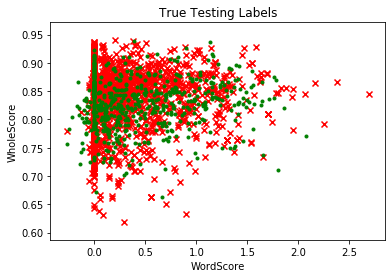

In [21]:
plotting(X_test, y_test, True)

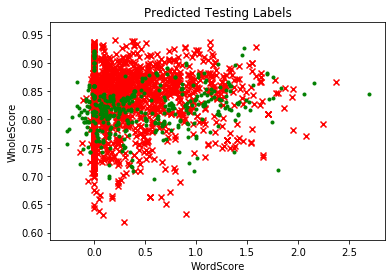

In [22]:
plotting(X_test, y_val, False)

### Trying to find a couple of examples for demonstration purposes

The following code will pull in specific examples where our model correctly predicted a good comment, correctly predicted a bad comment, incorrectly predicted a good comment, and incorrectly predicted a bad comment for the sake of trying to investigate what we could do better and to simply show people how our model is faring.

In [23]:
full_comment_data = pd.read_csv('files/full_comment_data_with_features1111.csv')
full_topics_data = pd.read_csv('files/full_topics_data1111.csv')

In [24]:
def grabbingExamples(x, yval, ytest, number):
    predicted_comment_row = full_comment_data[full_comment_data['WholeScore'] == x[number][1]]
    predicted_comment_row = predicted_comment_row.reset_index(drop=True)
    
    if len(predicted_comment_row.index) != 1:
        predicted_comment_row = predicted_comment_row[predicted_comment_row['WordScore'] == x[number][1]]
        predicted_comment_row = predicted_comment_row.reset_index(drop=True)

    predicted_topic_row = full_topics_data[full_topics_data['id'] == predicted_comment_row['submissionId'].iloc[0]]
    predicted_comment = predicted_comment_row['content'].values[0]
    predicted_article_text = predicted_topic_row['text'].values[0]
    predicted_article_url = predicted_topic_row['url'].values[0]
    predicted_article_reason_for_removal = predicted_comment_row['details'].values[0]
    yval = yval[number]
    ytest = ytest[number]
    if yval != ytest:
        print('Incorrect Prediction')
        if yval == False:
            print('Predicted bad comment, but was good comment')
        else:
            print('Predicted good comment, but was bad comment')
    else:
        print('Correct Prediction')
        if yval == False:
            print('Correctly predicted bad comment')
        else:
            print('Correctly predicted good comment')
    print('\nThe url that was predicted on: ')
    print(predicted_article_url)
    print('\nThe comment that was predicted on: ')
    print(predicted_comment)
    print('\nThe reason that the comment was removed: ')
    print(predicted_article_reason_for_removal)
    return predicted_article_text

In [25]:
def grabbingExamplesForArray(x, yval, ytest, number):
    predicted_comment_row = full_comment_data[(full_comment_data['WholeScore'] == x[number][1]) & (full_comment_data['WordScore'] == x[number][0])]
    predicted_comment_row = predicted_comment_row.reset_index(drop=True)
    
    if len(predicted_comment_row.index) != 1:
        return

    predicted_topic_row = full_topics_data[full_topics_data['id'] == predicted_comment_row['submissionId'].iloc[0]]
    predicted_comment = predicted_comment_row['content'].values[0]
    predicted_article_text = predicted_topic_row['text'].values[0]
    predicted_article_url = predicted_topic_row['url'].values[0]
    predicted_article_reason_for_removal = predicted_comment_row['details'].values[0]
    yval = yval[number]
    ytest = ytest[number]
    if yval != ytest:
        if yval == False:
            predicted_bad_but_is_good.append(number)
        else:
            predicted_good_but_is_bad.append(number)
    else:
        if yval == False:
            correct_prediction_bad.append(number)
        else:
            correct_prediction_good.append(number)

In [26]:
predicted_bad_but_is_good = []
predicted_good_but_is_bad = []
correct_prediction_good = []
correct_prediction_bad = []

for i in range(2386):
    grabbingExamplesForArray(X_test, y_val, y_test, i)
    

In [27]:
import random
def grabIncorrectlyBadComment():
    integ = random.randint(1, len(predicted_bad_but_is_good))
    number = predicted_bad_but_is_good[integ]
    text = grabbingExamples(X_test, y_val, y_test, number)
    print('\nThe index of the comment is ' + str(number))
    
    
def grabIncorrectlyGoodComment():
    integ = random.randint(1, len(predicted_good_but_is_bad))
    number = predicted_good_but_is_bad[integ]
    text = grabbingExamples(X_test, y_val, y_test, number)
    print('\nThe index of the comment is ' + str(number))
    
def grabCorrectGoodComment():
    integ = random.randint(1, len(correct_prediction_good))
    number = correct_prediction_good[integ]
    text = grabbingExamples(X_test, y_val, y_test, number)
    print('\nThe index of the comment is ' + str(number))
    
    
def grabCorrectBadComment():
    integ = random.randint(1, len(correct_prediction_bad))
    number = correct_prediction_bad[integ]
    text = grabbingExamples(X_test, y_val, y_test, number)
    print('\nThe index of the comment is ' + str(number))
    

In [44]:
grabIncorrectlyBadComment()

Incorrect Prediction
Predicted bad comment, but was good comment

The url that was predicted on: 
https://www.businessinsider.com/video-aide-trump-didnt-want-to-shake-hands-disgusting-supporters-2020-9

The comment that was predicted on: 
__I'm a bot.__

The [linked_article](https://www.businessinsider.com/video-aide-trump-didnt-want-to-shake-hands-disgusting-supporters-2020-9) *could not be evaluated* by TheFactualBot. https://www.businessinsider.com/video-aide-trump-didnt-want-to-shake-hands-disgusting-supporters-2020-9: Not Analyzable  

---
*This is a trial for The Factual bot. [How It Works](https://www.thefactual.com/how-it-works-reddit-bot.html). Please [message the bot](https://www.reddit.com/message/compose/?to=TheFactualBot) with any feedback so we can make it more useful for you.*

The reason that the comment was removed: 
nan

The index of the comment is 1921


In [29]:
grabIncorrectlyGoodComment()

Incorrect Prediction
Predicted good comment, but was bad comment

The url that was predicted on: 
https://www.reuters.com/article/us-health-coronavirus-usa-fauci/fauci-calls-white-house-effort-to-discredit-him-bizarre-a-mistake-idUSKCN24G2RZ

The comment that was predicted on: 
A sentiment oft repeated in pro-Trump circles is that Fauci hasn't "practiced medicine" (actually seen patients) in 20 years, putting him behind others in expertise, and making it more likely he's acting on old doctrine. I don't know how legitimate a claim that is, that's just what they say.

The reason that the comment was removed: 
remove

The index of the comment is 502


In [30]:
grabCorrectGoodComment()

Correct Prediction
Correctly predicted good comment

The url that was predicted on: 
https://www.npr.org/2020/07/01/886346437/hundreds-of-former-bush-officials-unite-to-endorse-joe-biden

The comment that was predicted on: 
**/r/NeutralNews is a curated space.** 

In order not to get your comment removed, please familiarize yourself with our [rules on commenting](https://www.reddit.com//r/neutralnews/wiki/guidelines#wiki_comments_.28good.2C_bad_.26amp.3B_ugly.29) before you participate:

#Comment Rules

We expect the following from all users:


1. Be courteous to other users.

1. Source your facts.

1. Be substantive.

1. Address the arguments, not the person.

1. All top level comments must contain a relevant link


If you see a comment that violates any of these essential rules, click the associated *report* link so mods can attend to it.

However, **please note that the mods will not remove comments or links reported for lack of neutrality**. There is [no neutrality requirement for 

In [31]:
grabCorrectBadComment()

Correct Prediction
Correctly predicted bad comment

The url that was predicted on: 
https://apnews.com/4d27d2b01e6e4bb3c9dd2050e5afd70e

The comment that was predicted on: 
Trump says veritably false beliefs over and over and will NEVER admit he is wrong. Many of his supporters hang on his every word, it's no wonder half of us don't even know whats true anymore. 

 See Trumps opinion on CFC'S and the ozone layer. He says the same story nearly every rally. https://youtu.be/0bWXMVNGr9U skip to 1:45.

Here he explains how how windmill noise gives you cancer. https://www.youtube.com/watch?v=Q0s5Zqmb09g

The reason that the comment was removed: 
confirm_ham

The index of the comment is 1169
